/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Навчання FeedForward (10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


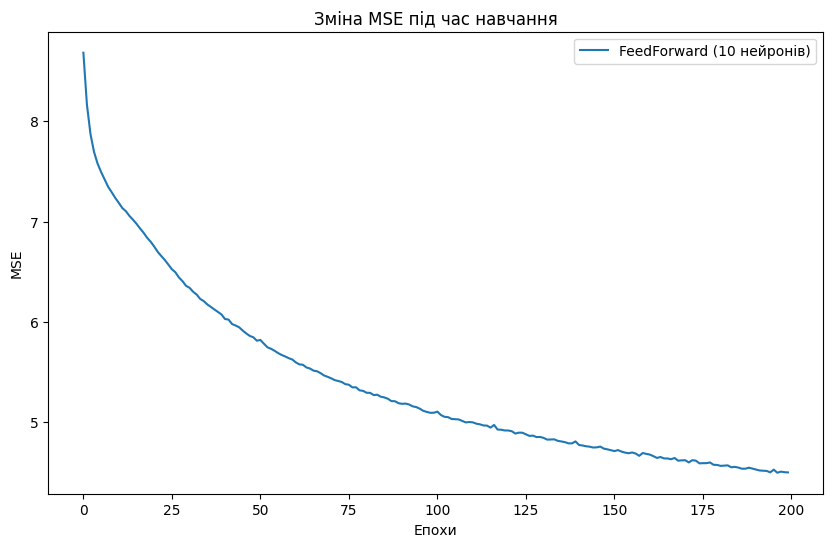

Навчання FeedForward (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


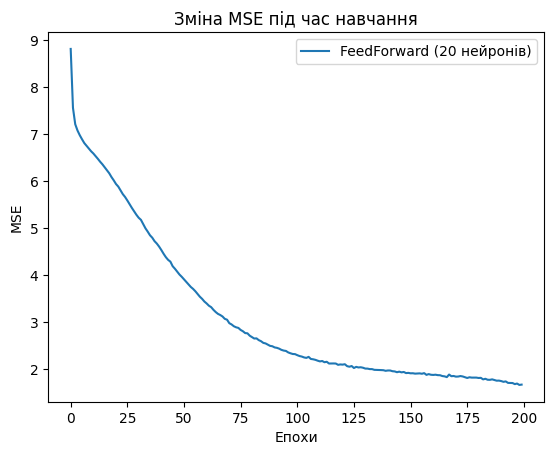

Навчання Cascade (20 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


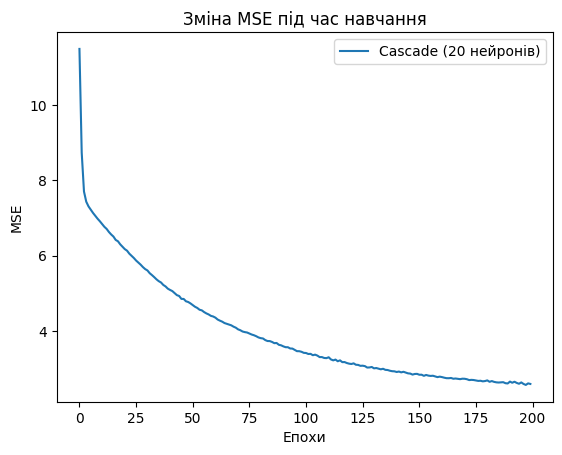

Навчання Cascade (2x10 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


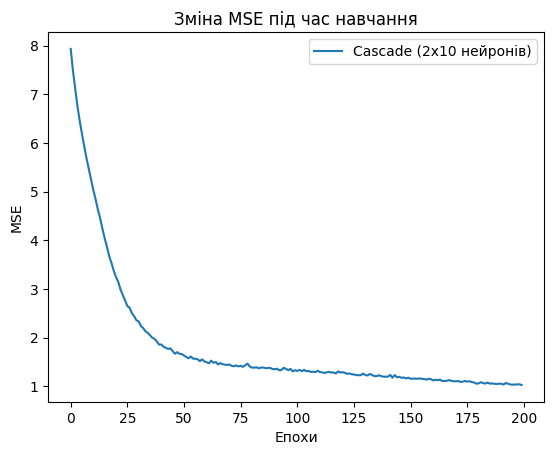

Навчання Elman (15 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


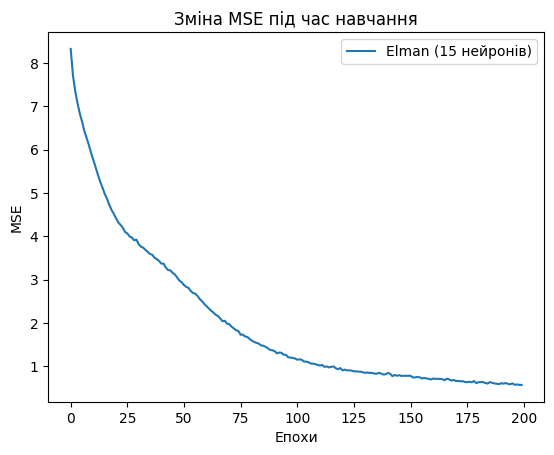

Навчання Elman (3x5 нейронів)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


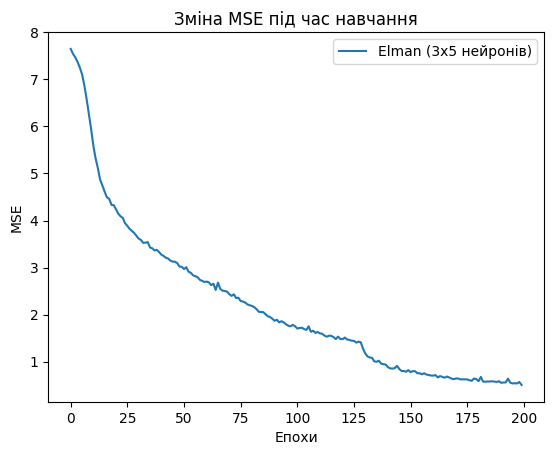

In [19]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Add 
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score 


#y(x1,x2) = x1*sin2 + x2*cosx1
def generate_data(n_samples=1000): 
    X = np.random.uniform(-5, 5, (n_samples, 2)) 
    Y = X[:, 0] * np.sin(X[:, 1]) + X[:, 1] * np.cos(X[:, 0])  
    return X, Y 
    
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=200, batch_size=10): 
    model.compile(optimizer='adam', loss='mse') 
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, Y_test)) 
    Y_pred = model.predict(X_test) 
    error = np.mean(np.abs((Y_test - Y_pred) / Y_test)) 
    r2 = r2_score(Y_test, Y_pred) 
    return history, error, Y_pred, r2 
    
X, Y = generate_data() 
X_train, X_test = X[:800], X[800:] 
Y_train, Y_test = Y[:800], Y[800:] 
inputs = Input(shape=(2,)) 
hidden1 = Dense(20, activation='relu')(inputs) 
output = Dense(1)(hidden1) 
output_cascade = Dense(1)(inputs) 
final_output = Add()([output, output_cascade]) 
cascade_model_1 = Model(inputs=inputs, outputs=final_output) 
inputs_2 = Input(shape=(2,)) 
hidden1_2 = Dense(10, activation='relu')(inputs_2)
hidden2_2 = Dense(10, activation='relu')(hidden1_2) 
output_2 = Dense(1)(hidden2_2) 
output_cascade_2 = Dense(1)(inputs_2) 
final_output_2 = Add()([output_2, output_cascade_2]) 
cascade_model_2 = Model(inputs=inputs_2, outputs=final_output_2) 

models = { 
    "FeedForward (10 нейронів)": Sequential([Input(shape=(2,)), Dense(10, activation='relu'), Dense(1)]), 
    "FeedForward (20 нейронів)": Sequential([Input(shape=(2,)), Dense(20, activation='relu'), Dense(1)]), 
    "Cascade (20 нейронів)": cascade_model_1, 
    "Cascade (2x10 нейронів)": cascade_model_2, 
    "Elman (15 нейронів)": Sequential([SimpleRNN(15, activation='relu', input_shape=(2, 1)), Dense(1)]), 
    "Elman (3x5 нейронів)": Sequential([SimpleRNN(5, activation='relu', return_sequences=True, input_shape=(2, 1)), 
    SimpleRNN(5, activation='relu', return_sequences=True), 
    SimpleRNN(5, activation='relu'),  Dense(1)]) 
} 

errors = {} 
predictions = {} 
r2_scores = {} 
plt.figure(figsize=(10, 6)) 

for name, model in models.items(): 
    print(f"Навчання {name}...") 
    if "Elman" in name: 
        X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1) ) 
        X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train_rnn, Y_train, X_test_rnn, Y_test) 
    else: 
        history, error, Y_pred, r2 = train_and_evaluate(model, X_train, Y_train, X_test, Y_test) 

    errors[name] = error 
    predictions[name] = Y_pred 
    r2_scores[name] = r2 
    plt.plot(history.history['loss'], label=name) 
    
    plt.title("Зміна MSE під час навчання")
    plt.xlabel("Епохи") 
    plt.ylabel("MSE") 
    plt.legend() 
    plt.show() 


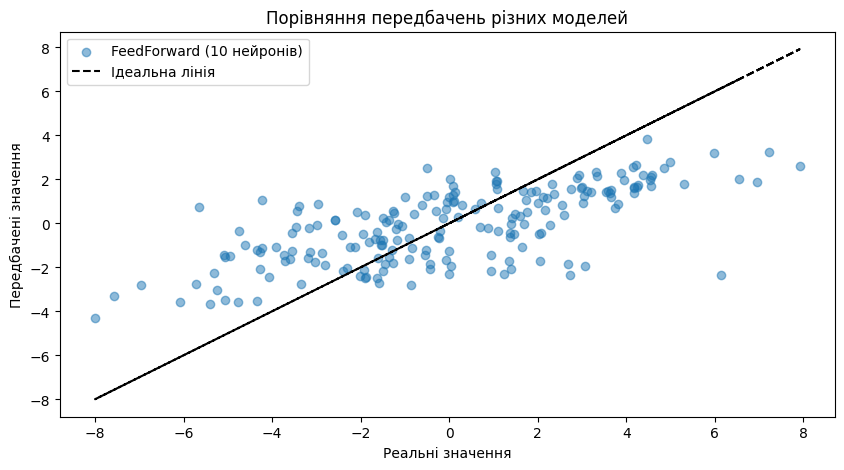

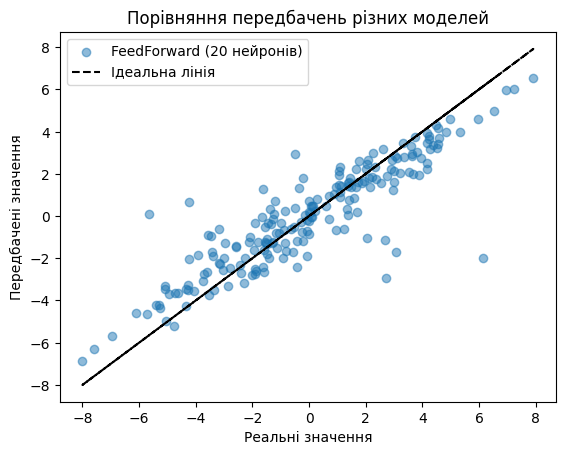

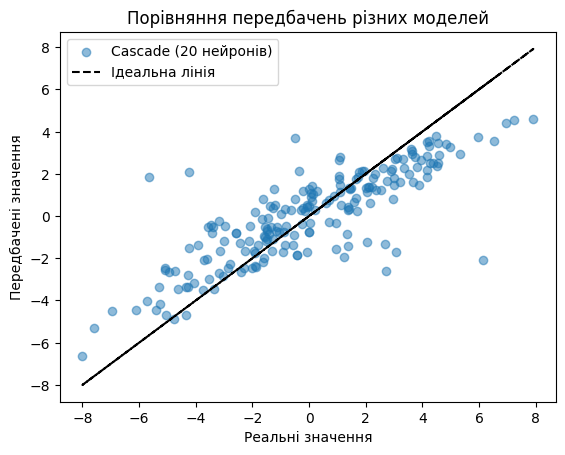

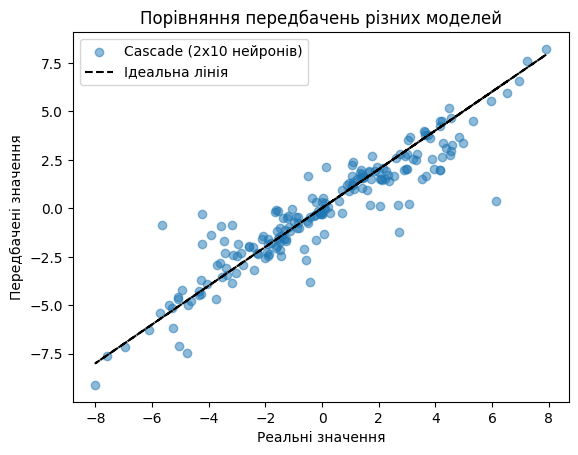

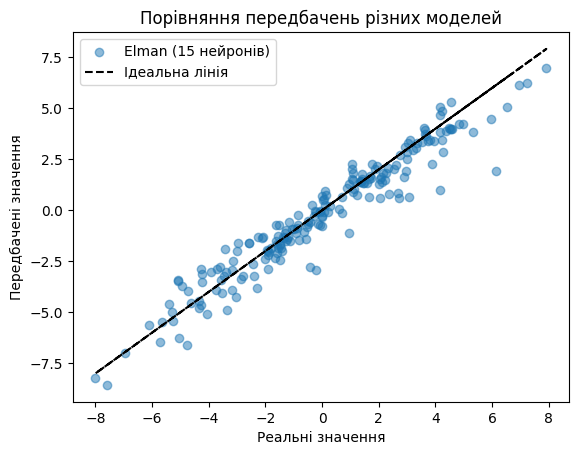

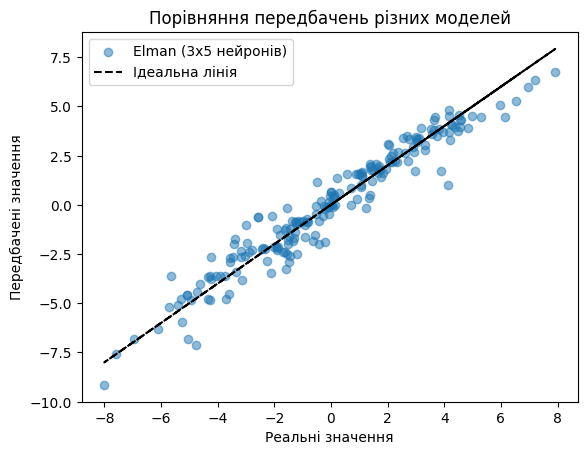

In [20]:
plt.figure(figsize=(10, 5)) 
for name, Y_pred in predictions.items(): 
    plt.scatter(Y_test, Y_pred, label=name, alpha=0.5) 
    plt.plot(Y_test, Y_test, 'k--', label="Ідеальна лінія") 
    plt.xlabel("Реальні значення") 
    plt.ylabel("Передбачені значення") 
    plt.legend()
    plt.title("Порівняння передбачень різних моделей") 
    plt.show() 


In [23]:
for name, error in errors.items(): 
    print(f"{name}: середня відносна помилка = {error:.4f}, R² = {r2_scores[name]:.4f}") 


FeedForward (10 нейронів): середня відносна помилка = 4.9965, R² = 0.4602
FeedForward (20 нейронів): середня відносна помилка = 7.0224, R² = 0.7894
Cascade (20 нейронів): середня відносна помилка = 6.2007, R² = 0.6722
Cascade (2x10 нейронів): середня відносна помилка = 7.6283, R² = 0.8640
Elman (15 нейронів): середня відносна помилка = 8.0006, R² = 0.9244
Elman (3x5 нейронів): середня відносна помилка = 8.3259, R² = 0.9364
